In [1]:
import scanpy as sc
import pandas as pd
import pickle
import numpy as np
import graph_tool.all as gt
%matplotlib inline
%pylab

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import anndata
adata=sc.read('adata_10x/adata_sc_10x.h5ad')
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20) #### df con i 20 geni significativi per gruppo
cell_annotation= pd.read_table('../sc_mixology/data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

In [3]:
g = pickle.load( open( "adata_10x/10x_graph_g.pkl", "rb" ))

# 1) state con 5 livelli

### creo il mio nested block state con 5 gruppi ben suddivisi e inizializzo la funzione collect info

In [5]:
state5= gt.minimize_nested_blockmodel_dl(g,deg_corr=False)

In [11]:
state5

<NestedBlockState object, with base <BlockState object with 65 blocks (65 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f184bd063d0>, at 0x7f1867351350>, and 5 levels of sizes [(860, 65), (65, 15), (15, 5), (5, 2), (2, 1)] at 0x7f18155cfdd0>

In [35]:
bs = state5.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state5.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())

In [50]:
state

<NestedBlockState object, with base <BlockState object with 68 blocks (65 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f0b4e6b2bd0>, at 0x7f0b4e5b0410>, and 10 levels of sizes [(860, 65), (65, 15), (15, 7), (7, 6), (6, 4), (4, 4), (4, 3), (3, 3), (3, 2), (2, 2)] at 0x7f0b4e711310>

In [38]:
pickle.dump(state, open('adata_10x/10x_equilibrate_final_test/10x_state_for_callback.pkl', 'wb'), 2)

In [4]:
state=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_state_for_callback.pkl','rb'))

In [12]:
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1
        

def collect_marginals(s):
   global pv
   pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [21]:
pickle.dump(state5, open('adata_10x/10x_equilibrate_final_test/10x_state5.pkl', 'wb'), 2)

In [5]:
state5=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_state5.pkl','rb'))

... storing 'cell_line' as categorical


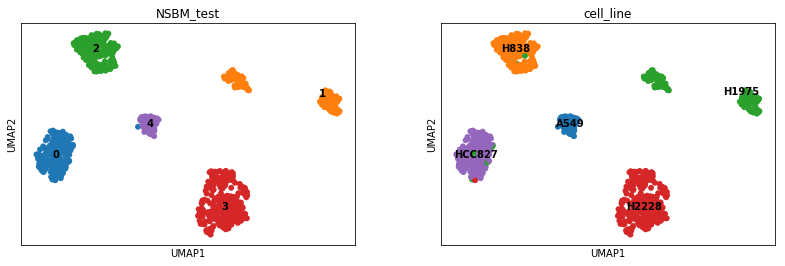

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0             1     0      4      1     188
1             0     0    127      0       0
2             0   176      7      0       0
3             0     0      0    295       0
4            61     0      0      0       0

In [6]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state5.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### a) force niter=1; mcmc niter=100.000; d=0.01

In [18]:
bs = state5.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estate5 = state5.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estate5, force_niter=1, mcmc_args=dict(niter=100000), callback=collect_info)
estate5

<NestedBlockState object, with base <BlockState object with 67 blocks (64 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f184bd063d0>, at 0x7f181513b4d0>, and 10 levels of sizes [(860, 64), (64, 17), (17, 5), (5, 2), (2, 2), (2, 2), (2, 2), (2, 1), (1, 1), (1, 1)] at 0x7f1815134d10>

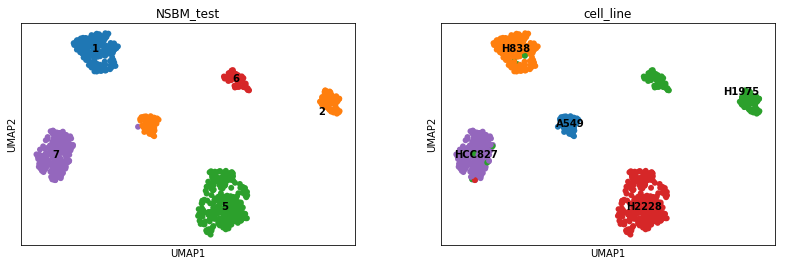

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
1             0   176      7      0       0
2            61     0     71      0       0
5             0     0      0    295       0
6             0     0     56      0       0
7             1     0      4      1     188

In [19]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate5a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [31]:
pickle.dump(estate5, open('adata_10x/10x_equilibrate_final_test/10x_estate5a.pkl', 'wb'), 2)
pickle.dump(h, open('adata_10x/10x_equilibrate_final_test/10x_h_estate5a.pkl', 'wb'), 2)
pickle.dump(pv, open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5a.pkl', 'wb'), 2)

In [33]:
estate5a=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_estate5a.pkl', 'rb'))
h5a=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_h_estate5a.pkl', 'rb'))
pv5a=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5a.pkl', 'rb'))

### b) force niter=1; mcmc niter=10.000; d=0.1

In [41]:
bs = state5.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estate5 = state5.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estate5, force_niter=1, mcmc_args=dict(niter=10000,d=0.1), callback=collect_info)
estate5

<NestedBlockState object, with base <BlockState object with 68 blocks (65 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f0b4e94d250>, at 0x7f0b4e5f4410>, and 10 levels of sizes [(860, 65), (65, 14), (14, 5), (5, 2), (2, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f0b4e5f4390>

In [36]:
pickle.dump(estate5, open('adata_10x/10x_equilibrate_final_test/10x_estate5b.pkl', 'wb'), 2)
pickle.dump(h, open('adata_10x/10x_equilibrate_final_test/10x_h_estate5b.pkl', 'wb'), 2)
pickle.dump(pv, open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5b.pkl', 'wb'), 2)

In [37]:
estate5b=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_estate5b.pkl', 'rb'))
h5b=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_h_estate5b.pkl', 'rb'))
pv5b=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5b.pkl', 'rb'))

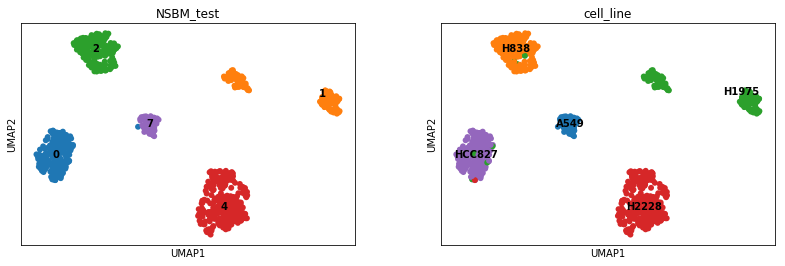

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0             1     0      4      1     188
1             0     0    127      0       0
2             0   176      7      0       0
4             0     0      0    295       0
7            61     0      0      0       0

In [42]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate5b.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### c) force niter=1; mcmc niter=20.000; d=0.05

In [44]:
bs = state5.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estate5 = state5.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estate5, force_niter=1, mcmc_args=dict(niter=20000,d=0.05), callback=collect_info)
estate5

<NestedBlockState object, with base <BlockState object with 68 blocks (66 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f0b4e94d250>, at 0x7f0b4e5ee4d0>, and 10 levels of sizes [(860, 66), (66, 15), (15, 5), (5, 3), (3, 2), (2, 2), (2, 1), (1, 1), (1, 1), (1, 1)] at 0x7f0b4e86f690>

In [46]:
pickle.dump(estate5, open('adata_10x/10x_equilibrate_final_test/10x_estate5c.pkl', 'wb'), 2)
pickle.dump(h, open('adata_10x/10x_equilibrate_final_test/10x_h_estate5c.pkl', 'wb'), 2)
pickle.dump(pv, open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5c.pkl', 'wb'), 2)

In [47]:
estate5c=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_estate5c.pkl', 'rb'))
h5c=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_h_estate5c.pkl', 'rb'))
pv5c=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5c.pkl', 'rb'))

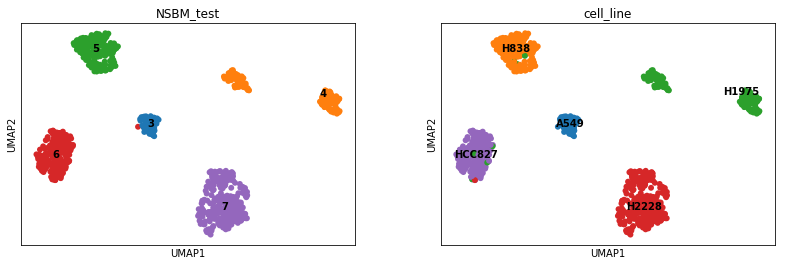

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
3            61     0      0      0       0
4             0     0    127      0       0
5             0   176      7      0       0
6             1     0      4      1     188
7             0     0      0    295       0

In [48]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate5c.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

##### sembra che aumentando il niter di mcmc_sweep a 100.000 l'algoritmo funzioni su state5; sembra inoltre che sia possibile velocizzare il processo abbassando il niter di sweep, aumentando la d (da 0.01 a 0.1). tuttavia se non faccio un niter elevato di equilibrate, non ottengo ne pv ne h
### c) force niter=10; mcmc niter=20.000; d=0.05

In [52]:
bs = state5.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estate5 = state5.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estate5, force_niter=10, mcmc_args=dict(niter=20000, d=0.05),callback=collect_info)
estate5

<NestedBlockState object, with base <BlockState object with 67 blocks (64 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f0b4e94d250>, at 0x7f0b4a6e48d0>, and 10 levels of sizes [(860, 64), (64, 17), (17, 9), (9, 7), (7, 4), (4, 4), (4, 3), (3, 3), (3, 2), (2, 2)] at 0x7f0b4a6e4850>

In [55]:
pickle.dump(estate5, open('adata_10x/10x_equilibrate_final_test/10x_estate5d.pkl', 'wb'), 2)
pickle.dump(h, open('adata_10x/10x_equilibrate_final_test/10x_h_estate5d.pkl', 'wb'), 2)
pickle.dump(pv, open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5d.pkl', 'wb'), 2)

In [56]:
estate5d=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_estate5d.pkl', 'rb'))
h5d=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_h_estate5d.pkl', 'rb'))
pv5d=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5d.pkl', 'rb'))

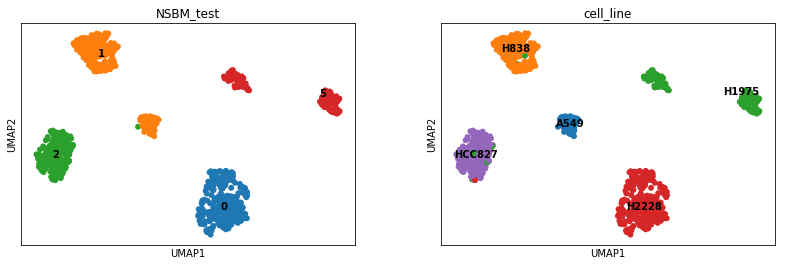

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0             0     0      0    295       0
1            61   176      7      0       0
2             1     0      4      1     188
5             0     0    127      0       0

In [57]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate5d.project_level(4).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

##### ok non viene bene, cerco di mettere i parametri giusti, per non far uscire errore dalla callback info, devo prima fare un giro di equilibrate senza callback e poi impostare la callback sul nestedblock object che risulta dalla prima equilibrate
### e) force_niter=100, mcmc_niter=2000, d=0.05

In [7]:
bs = state5.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estate5 = state5.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estate5, force_niter=100, mcmc_args=dict(niter=2000, d=0.05),callback=collect_info)
estate5

<NestedBlockState object, with base <BlockState object with 68 blocks (65 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f28c7b53510>, at 0x7f28c4e54bd0>, and 10 levels of sizes [(860, 65), (65, 15), (15, 7), (7, 6), (6, 4), (4, 3), (3, 3), (3, 3), (3, 3), (3, 2)] at 0x7f28c4e54c90>

In [8]:
pickle.dump(estate5, open('adata_10x/10x_equilibrate_final_test/10x_estate5e.pkl', 'wb'), 2)
pickle.dump(h, open('adata_10x/10x_equilibrate_final_test/10x_h_estate5e.pkl', 'wb'), 2)
pickle.dump(pv, open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5e.pkl', 'wb'), 2)

In [9]:
estate5e=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_estate5d.pkl', 'rb'))
h5e=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_h_estate5d.pkl', 'rb'))
pv5e=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5d.pkl', 'rb'))

... storing 'cell_line' as categorical


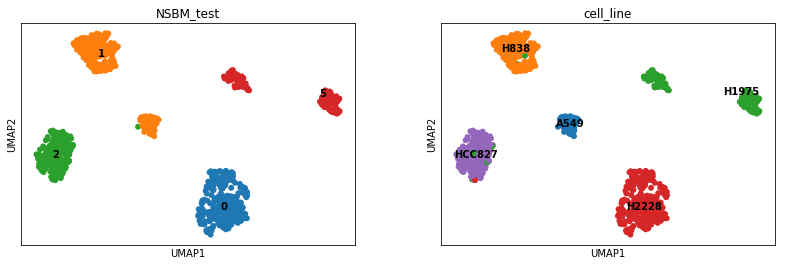

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0             0     0      0    295       0
1            61   176      7      0       0
2             1     0      4      1     188
5             0     0    127      0       0

In [10]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate5e.project_level(4).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

##### prima di fare partire ogni callback che abbia collect marginals, faccio un refresh della callback
### f) force niter=10; mcmc niter=20000; d=0.15

In [13]:
bs = state5.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estate5 = state5.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estate5, force_niter=10, mcmc_args=dict(niter=20000, d=0.15),callback=collect_info)
estate5

<NestedBlockState object, with base <BlockState object with 68 blocks (63 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f28c7b53510>, at 0x7f28c5086190>, and 10 levels of sizes [(860, 63), (63, 14), (14, 8), (8, 4), (4, 4), (4, 3), (3, 2), (2, 2), (2, 2), (2, 2)] at 0x7f28c5086110>

In [14]:
pickle.dump(estate5, open('adata_10x/10x_equilibrate_final_test/10x_estate5f.pkl', 'wb'), 2)
pickle.dump(h, open('adata_10x/10x_equilibrate_final_test/10x_h_estate5f.pkl', 'wb'), 2)
pickle.dump(pv, open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5f.pkl', 'wb'), 2)

In [15]:
estate5f=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_estate5d.pkl', 'rb'))
h5f=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_h_estate5d.pkl', 'rb'))
pv5f=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_pv_estate5d.pkl', 'rb'))

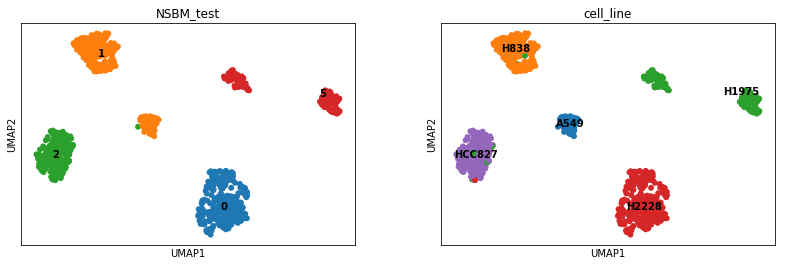

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0             0     0      0    295       0
1            61   176      7      0       0
2             1     0      4      1     188
5             0     0    127      0       0

In [16]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate5f.project_level(4).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

#### la soluzione migliore sembra essere quella di non utilizzare equilibrate ma solo mcmc sweep, se voglio anche le call back information allora uso equilibrate
# 2) con state 4, questi senza callback

In [17]:
state4= gt.minimize_nested_blockmodel_dl(g,deg_corr=False)
state4

<NestedBlockState object, with base <BlockState object with 61 blocks (61 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f28dc366110>, at 0x7f28c4d7e990>, and 5 levels of sizes [(860, 61), (61, 13), (13, 4), (4, 2), (2, 1)] at 0x7f28c4fac650>

In [18]:
pickle.dump(state4, open('adata_10x/10x_equilibrate_final_test/10x_state4.pkl', 'wb'), 2)

In [19]:
state4=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_state4.pkl','rb'))

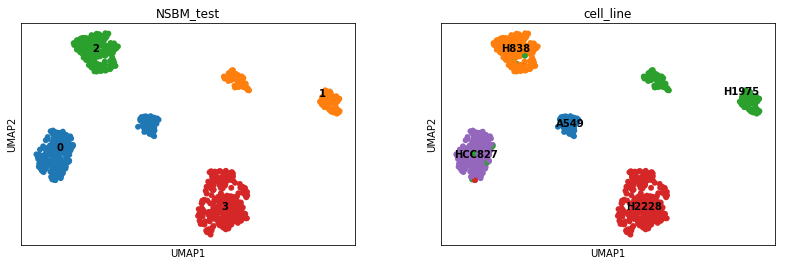

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0            62     0      4      1     188
1             0     0    127      0       0
2             0   176      7      0       0
3             0     0      0    295       0

In [20]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state4.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### a) force niter=1; mcmc niter=100.000; d=0.01 (1:45)

In [32]:
bs = state4.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estate4 = state4.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estate4, force_niter=1, mcmc_args=dict(niter=100000))
estate4

<NestedBlockState object, with base <BlockState object with 64 blocks (61 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f28c4d79690>, at 0x7f28c073fdd0>, and 10 levels of sizes [(860, 61), (61, 14), (14, 5), (5, 3), (3, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f28c073af10>

In [33]:
pickle.dump(estate4, open('adata_10x/10x_equilibrate_final_test/10x_estate4a.pkl', 'wb'), 2)

In [34]:
estate4a=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_estate4a.pkl', 'rb'))

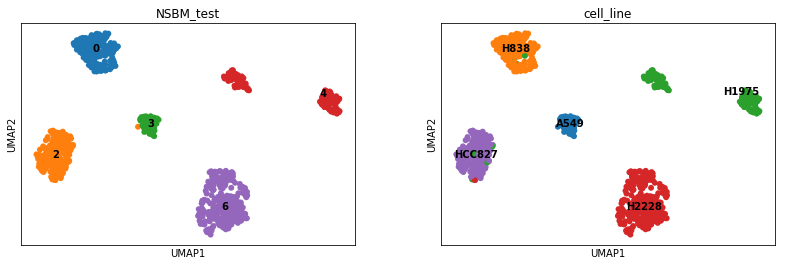

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0             0   176      7      0       0
2             1     0      4      1     188
3            61     0      0      0       0
4             0     0    127      0       0
6             0     0      0    295       0

In [35]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate4a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### b) force niter=1; mcmc niter=10.000;d=0.1 (0:11)

In [36]:
bs = state4.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estate4 = state4.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estate4, force_niter=1, mcmc_args=dict(niter=10000,d=0.1))
estate4

<NestedBlockState object, with base <BlockState object with 62 blocks (59 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f28c4d79690>, at 0x7f28c06e13d0>, and 10 levels of sizes [(860, 59), (59, 15), (15, 4), (4, 2), (2, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f28c06e1750>

In [37]:
pickle.dump(estate4, open('adata_10x/10x_equilibrate_final_test/10x_estate4b.pkl', 'wb'), 2)

In [38]:
estate4b=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_estate4b.pkl', 'rb'))

### c) force niter=1; mcmc niter=50.000;d=0.1 (1:00)

In [39]:
bs = state4.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estate4 = state4.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estate4, force_niter=1, mcmc_args=dict(niter=50000,d=0.1))
estate4

<NestedBlockState object, with base <BlockState object with 63 blocks (60 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f28c4d79690>, at 0x7f28c07bc910>, and 10 levels of sizes [(860, 60), (60, 14), (14, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f28c07bc810>

In [40]:
pickle.dump(estate4, open('adata_10x/10x_equilibrate_final_test/10x_estate4c.pkl', 'wb'), 2)

In [41]:
estate4c=pickle.load(open('adata_10x/10x_equilibrate_final_test/10x_estate4c.pkl', 'rb'))

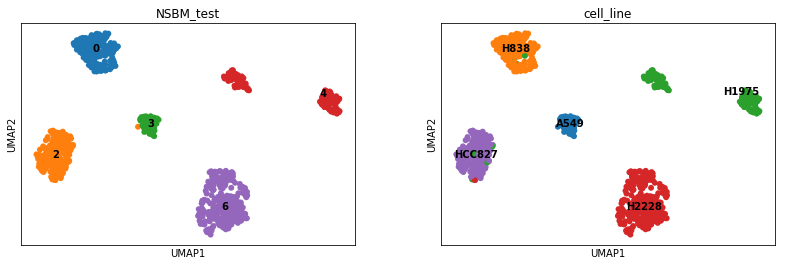

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0             0   176      7      0       0
2             1     0      4      1     188
3            61     0      0      0       0
4             0     0    127      0       0
6             0     0      0    295       0

In [42]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate4a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

# CON UN SOLO EQUILIBRATE(QUINDI COME SENZA FARLO) FUNZIONA BENE SIA CON STATE4 CHE CON STATE5
# NON CAPISCO PERCHÈ SE USO LA CALLBACK, FACENDO PIÙ CICLI DI EQUILIBRATE NON MI DIA 5 GRUPPI. 
# PROVERÒ CON LA MULTIFLIP